We want to use the model and algorithm of Tutorial--Van der Pol's dynamics with spike train observations.ipynb on the data in the folder Data.

In [63]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
import pickle


# .py
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import PointProcess
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from linkfunctions import Exp
from models import PointProcessGPSDEmodel, GPSDE
sys.path.append("../Data")
from Load_plot_data import load_neuron_data, roster_plot

# Load the data and modify its format

In [64]:
#Load data
ids,times=load_neuron_data('../Data/Cellline1_Date190328_Chip2135.npz')
N=np.max(ids) # Number of neurons
trLen=np.array([np.max(times)]) #Tmax must be an array to have one for each trial

The data from the files is of the form
( id : neurons ids,
times : times of spike )

For the model we need a list of array where array i contains the times at which neuron i had a spike

We can observe using unique and some tests that the ids are all the numbers between 0 and 1016 except 131 and 899. We suppose that they are not present beacause they didn't have a spike.

In [65]:
Yspike=[]
for i in range(N):
    Yspike.append(times[ids==i])
print(len(Yspike))

#For now there is only one trial, to change if we want to define trials
Yspike=[Yspike]

1016


In [66]:
#Reduce the dataset (only one trial)
N=100
timemax=120

#Yspike=Yspike[0][:N] #keep only n first neuron

#keep n most actives
Yspike=Yspike[0]
Yspike=sorted(Yspike,key=lambda x:x.shape[0],reverse=True)[:N]
print(Yspike[-1].shape[0])

for i in range(N):  #reduce the time
    Yspike[i]=Yspike[i][Yspike[i]<=timemax]
Yspike=[Yspike]
#print(Y_spike_small[0])
trLen=np.array([timemax]) #Tmax must be an array to have one for each trial

2545


# Choices for the model

In [67]:
#Choice of variables
dtgrid = 0.004 # discretisation for solving ODEs (0.01 create not semipos matrix)
xDim = 2 # two latents

In [68]:
#Choice of model components
link = Exp() # exponential link function (to define nonlinearity in likelihood )
like = PointProcess(Yspike, link, trLen, dtstep=dtgrid, nLeg=100) # point process likelihood 
kern = RBF(xDim) # RBF kernel

#To initialize the Affine mapping from latent to observations
C = 2.*np.random.rand(xDim,N) * np.random.choice([-1,1],size=(xDim,N)) 
d = 0.1*np.random.randn(1,N)
outputMapping = AffineMapping(torch.tensor(C), torch.tensor(d)) # affine output mapping, used inn the forward of the model

In [69]:
#Choose the inducing points and transition function

# generater inducing point locations on a 2D grid (for sparse gp)
xmin, xmax = -2., 2.
Zs1, Zs2 = torch.meshgrid([torch.linspace(xmin,xmax,5), torch.linspace(xmin,xmax,5)])
numZ = 25
Zs = torch.cat((Zs1.reshape(-1,1),Zs2.reshape(-1,1)),dim=1)

transfunc = SparseGP(kern, Zs) # choose sparse GP as a transition function
transfunc.q_mu.data = torch.randn(transfunc.q_mu.size()).type(torch.float64) # random initialisation for inducing point posterior mean

# uncomment to instead condition on fixed points
#Zs_fx = torch.tensor([0., 0.]).view(-1,xDim)
# transition function conditioned on fixed point
#transfunc = SparseGP(kern, Zs, Zs_fx) 

# Build the model

In [70]:
#Build the model

# build point procces generative model for continuous time spike-time observations
model = PointProcessGPSDEmodel(xDim, transfunc, outputMapping, like, nLeg=100)

# assemble inference algorithm
inference = GaussMarkovLagrange(xDim, trLen, learningRate=1, dtstep=dtgrid)

# create GPSDE model object (final object)
myGPSDE = GPSDE(model, inference)

# fix inducing points on chosen grid
myGPSDE.model.transfunc.Zs.requires_grad = False

# Run the algorithm and save the results

In [71]:
myGPSDE.variationalEM(niter=1,eStepIter=1, mStepIter=1)

inference time=29.752474308013916
learning time=162.77311277389526
update time0.0
-------------------------------------------------------
iter   objective    log-like      kl-div     f-prior
-------------------------------------------------------
   0   11941.869  -10032.901    1259.544    -649.425


In [72]:
#Save the results
torch.save(myGPSDE.model,'Graph_and_modelsave/GPSDE_model.pt')
with open("Graph_and_modelsave/GPSDE_inference.pkl",'wb') as file:
    pickle.dump(myGPSDE.inference,file)

# Open the results

In [73]:
model=torch.load('Graph_and_modelsave/GPSDE_model.pt')
with open("Graph_and_modelsave/GPSDE_inference.pkl",'rb') as file:
    inference=pickle.load(file)

# Visualisation

In [74]:
idx = 0 #trial considered
testTimes = torch.linspace(0,trLen[idx],int(trLen[idx]/0.001)) #testing times

m, S = inference.predict_marginals(idx, testTimes) #evaluate gp at new points for trial idx (long)
mr, Sr, Corth = model.outputMapping.orthogonaliseLatents(m,S) # orthogonalized subspace ? why?

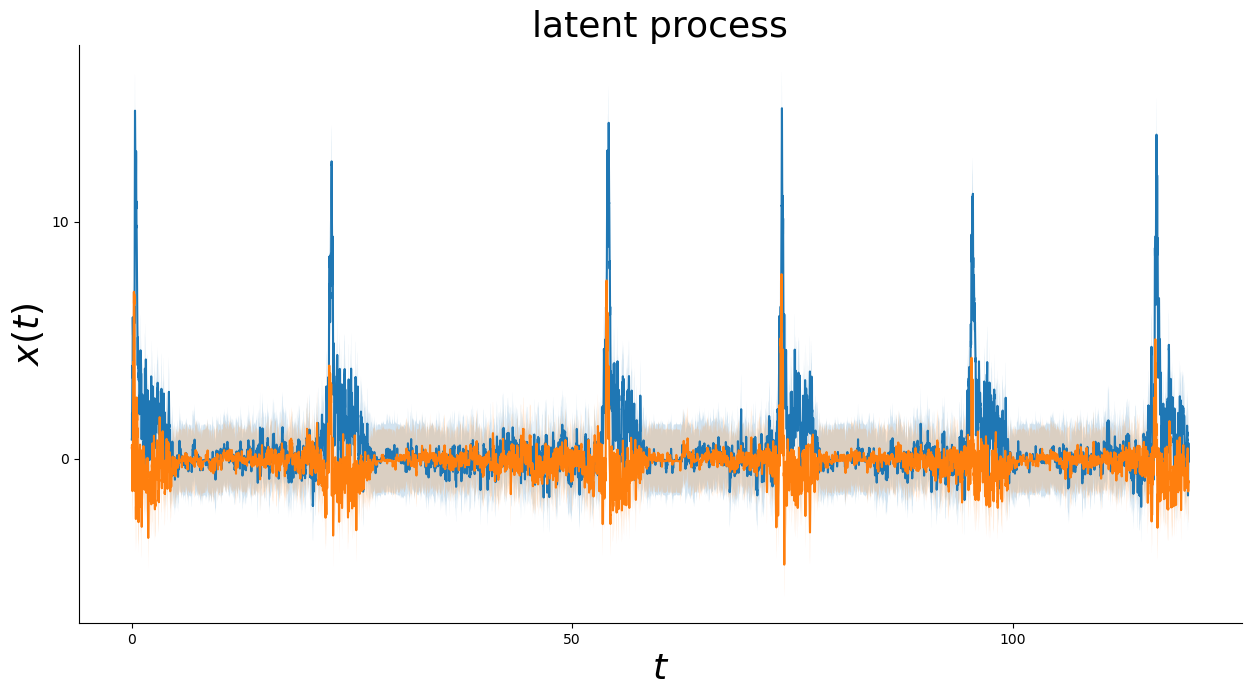

In [75]:
# plot the latent path and data in orthogonalised subspace
f, ax = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(15)
for i in range(xDim):
#     ax.plot(testTimes.numpy(),xpath[idx],color='black',linewidth=0.5,label='x(t)')
    ax.plot(testTimes.numpy(),mr[:,0,i].detach().squeeze().numpy(), label='$m_x(t)$')
    ax.fill_between(testTimes.numpy(), mr[:,0,i].detach().numpy()+np.sqrt(Sr[:,i,i].detach().numpy()), 
                mr[:,0,i].detach().squeeze().numpy()-np.sqrt(Sr[:,i,i].detach().numpy()), alpha=0.2)

# plot where observations lie
ax.locator_params(nbins=4)
ax.set_ylabel('$x(t)$',fontsize=26)
ax.set_xlabel('$t$',fontsize=26)
ax.set_title('latent process',fontsize=26)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('Graph_and_modelsave/Latent_graph.pdf')
plt.show()

In [76]:
# visualise learned transition function 
ngrid = 20
xmin = -2.5
xmax = 2.5
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = model.transfunc.predict(xygrid.unsqueeze(0))

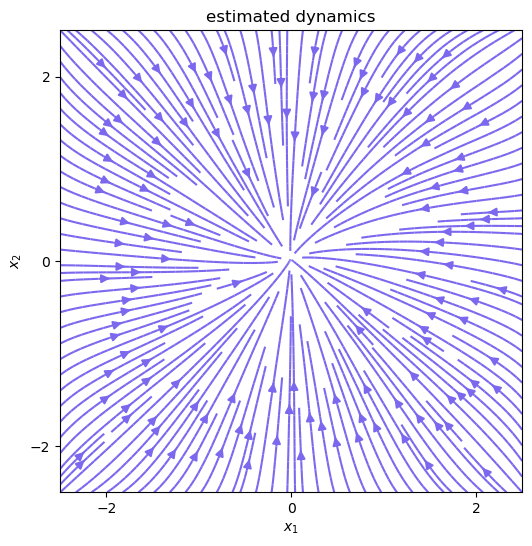

In [77]:
# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))

plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

        
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics')
plt.axis('square')
plt.locator_params(nbins=3)
plt.savefig('Graph_and_modelsave/dynamics.pdf')
plt.show()